# Artificial Intelligence UE
## Assignment 2 - Heuristic Search



In this assignment you are looking at two heuristic search algorithms: Greedy Best First Search, and A* search. We also look at a few different heuristics to test out the algorithms. 

The algorithms have been explained in the lecture (VO) and we gave you some additional information in the exercise (UE). Please refer to the lecture slides (VO) for the pseudo algorithms and the exercise slides (UE) for additional hints.

<div class="alert alert-warning">

<p><strong>Automatic Grading:</strong></p>
<ul>
<li>Replace the placeholders <code># YOUR CODE HERE</code>, <code>raise NotImplementedError()</code> with your code.</li>
<li>Do not rename any of the already existing variables (this might lead to hidden tests failing / not working).</li>
<li>Do not delete or add cells.</li>
</ul>


<li><code>solve()</code> should return the found solution node or <code>None</code> if no solution is found. You do not need to store the path, the function <code>node.get_action_sequence()</code> can be used to retrieve it later via backtracking.</li>
<li>The heuristics return <code>-1</code> for now; change them so that they return the distance that they represent!</li>
<li>Use a <code>set()</code> to store already visited nodes (when needed).</li>
<li>Use the imported data structures <code>Queue</code>, <code>Stack</code>, and <code>PriorityQueue</code> as the fringe / frontier (choose the right datatype depending on the algorithm)</li>
</ul>
</div>

In [1]:
# import stuff
from pig_lite.problem.base import Problem, Node
from pig_lite.datastructures.queue import Queue
from pig_lite.datastructures.stack import Stack
from pig_lite.datastructures.priority_queue import PriorityQueue
from pig_lite.instance_generation.problem_factory import ProblemFactory

import math
import random
import numpy as np

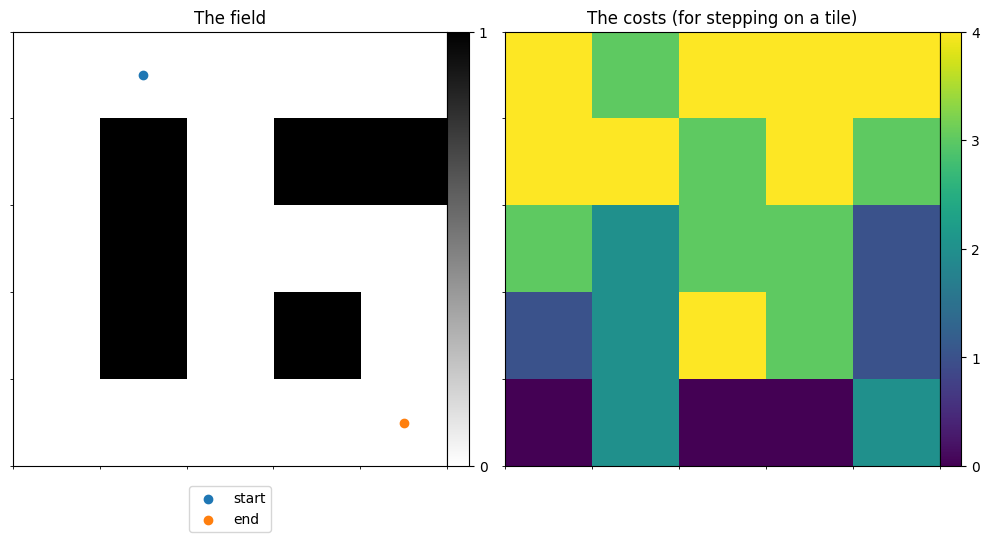

In [2]:
# as a reminder, this way we can visualize a particular problem (here: a maze)
factory = ProblemFactory()
maze = factory.create_problem_from_json(json_path='boards/tiny0.json')
maze.visualize()

<div class="alert alert-warning">
Now it's your turn to implement some heuristics and search algorithms - all spots that need your attention are marked with <code># YOUR CODE HERE</code>!
</div>

## Implementing Heuristics

Here, you first have to implement several heuristics. More precisely, we look at the City Block, Euclidean, and Chebyshev distance. We discussed how these distances are computed in class, so make sure to check out the slides if you cannot recall them.

For comparison, we also provide you with a random distance heuristic - feel free to use them for debugging your implementations if it helps! 

In [3]:
# this is a random heuristic - it returns a random number as the distance between two nodes
# we use it for testing - you can also use it for debbuging if you want
def random_heuristic(current: Node, goal: Node):
    return random.random()

def cityblock_heuristic(current: Node, goal: Node):
    # YOUR CODE HERE
    curr_x, curr_y = current.state
    goal_x, goal_y = goal.state
    return abs(curr_x - goal_x) + abs(curr_y - goal_y)

def euclidean_heuristic(current: Node, goal: Node):
    # YOUR CODE HERE
    curr_x, curr_y = current.state
    goal_x, goal_y = goal.state
    return math.sqrt((curr_x - goal_x)**2 + (curr_y - goal_y)**2)

def chebyshev_heuristic(current: Node, goal: Node):
    # YOUR CODE HERE
    curr_x, curr_y = current.state
    goal_x, goal_y = goal.state
    return max(abs(curr_x - goal_x), abs(curr_y - goal_y))

### Check City Block Heuristic

In [4]:
# this is a testing cell, do not edit or delete

maze = ProblemFactory().create_problem_from_json(json_path='boards/tiny0.json')

assert(cityblock_heuristic(maze.get_start_node(), maze.get_end_node()) != -1), "it seems like you might not have implemented this heuristic yet, the distance is -1"


### Check Euclidean Heuristic

In [5]:
# this is a testing cell, do not edit or delete

maze = ProblemFactory().create_problem_from_json(json_path='boards/tiny0.json')

assert(euclidean_heuristic(maze.get_start_node(), maze.get_end_node()) != -1), "it seems like you might not have implemented this heuristic yet, the distance is -1"


### Check Chebyshev Heuristic

In [6]:
# this is a testing cell, do not edit or delete

maze = ProblemFactory().create_problem_from_json(json_path='boards/tiny0.json')

assert(chebyshev_heuristic(maze.get_start_node(), maze.get_end_node()) != -1), "it seems like you might not have implemented this heuristic yet, the distance is -1"


## Implementing GBFS


state (4, 4) was reached following the sequence ['R', 'D', 'D', 'D', 'D', 'R', 'R'] (cost: 16, depth: 7)


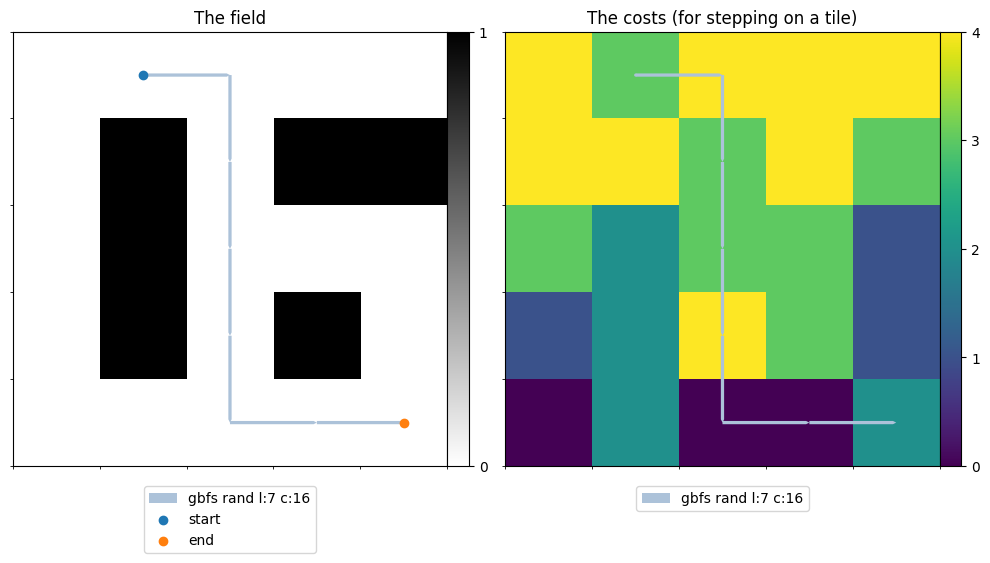

In [20]:
class GBFS(object):
    def __init__(self, heuristic):
        self.heuristic = heuristic
        self.visited = set()
        self.fringe = PriorityQueue()
    
    def solve(self, problem: Problem):
        # make sure to initialise self.visited and self.fringe here! 
        # YOUR CODE HERE
        start_node = problem.get_start_node()
        
        self.fringe.put(self.heuristic(start_node, problem.get_end_node()), start_node)
        
        while self.fringe.has_elements():
            current = self.fringe.get()
            
            if problem.is_end(current):
                return current
                
            if current.state in self.visited:
                continue
                
            self.visited.add(current.state)
            
            for next_node in problem.successors(current):
                if next_node.state not in self.visited:
                    self.fringe.put(self.heuristic(next_node, problem.get_end_node()), next_node)
        
        return None


# reset maze before search
maze.reset()
gbfs_rand = GBFS(random_heuristic)
gbfs_rand_sol = gbfs_rand.solve(maze)
if gbfs_rand_sol is not None: 
    gbfs_rand_sol.pretty_print()
    maze.visualize(sequences=[('gbfs rand', "".join(maze.get_action_sequence(gbfs_rand_sol)))])

### Basic checks

In [21]:
# this is a testing cell, do not edit or delete

assert(gbfs_rand_sol is not None), "GBFS did not return a solution"
assert(gbfs_rand_sol.state == (4, 4)), "GBFS did not return the expected solution"


### Check visited set

In [22]:
# this is a testing cell, do not edit or delete

assert(gbfs_rand.visited is not None), "it seems you did not correctly initialize the visited set"


### Check fringe

In [23]:
# this is a testing cell, do not edit or delete

assert(gbfs_rand.fringe is not None), "it seems you did not correctly initialize the fringe"


## Implementing A*


state (4, 4) was reached following the sequence ['R', 'D', 'D', 'D', 'D', 'R', 'R'] (cost: 16, depth: 7)


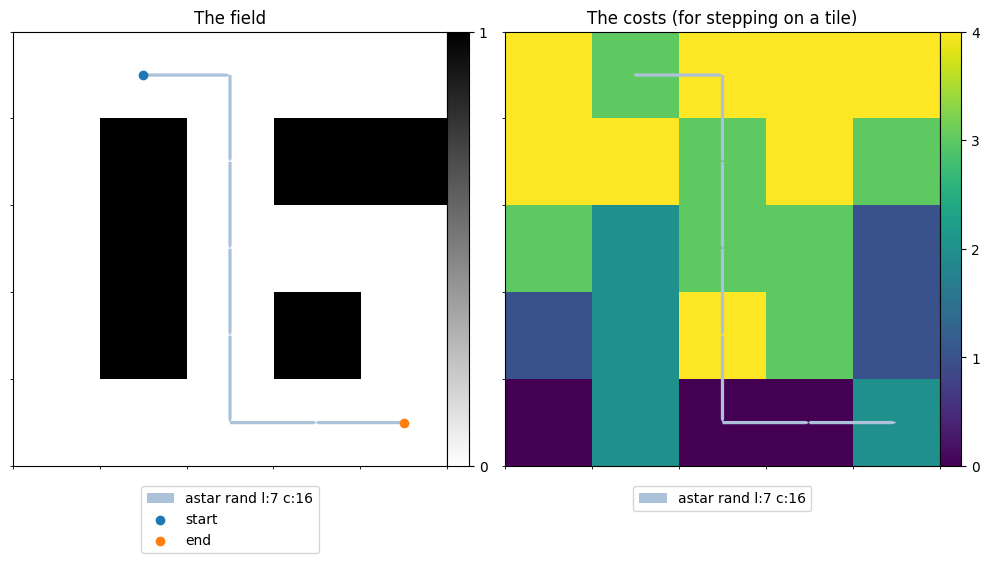

In [24]:
class ASTAR(object):
    def __init__(self, heuristic):
        self.heuristic = heuristic
        self.visited = set()
        self.fringe = PriorityQueue()
    
    def solve(self, problem: Problem):
        # make sure to initialise self.visited and self.fringe here! 
        # YOUR CODE HERE
        start_node = problem.get_start_node()
        
        self.fringe.put(start_node.cost + self.heuristic(start_node, problem.get_end_node()), start_node)
        
        while self.fringe.has_elements():
            current = self.fringe.get()
            
            if problem.is_end(current):
                return current
                
            if current.state in self.visited:
                continue
                
            self.visited.add(current.state)
            
            
            for next_node in problem.successors(current):
                if next_node.state not in self.visited:
                    f_value = next_node.cost + self.heuristic(next_node, problem.get_end_node())
                    self.fringe.put(f_value, next_node)
        
        return None

# reset maze before search
maze.reset()
astar_rand = ASTAR(random_heuristic)
astar_rand_sol = astar_rand.solve(maze)
if astar_rand_sol is not None: 
    astar_rand_sol.pretty_print()
    maze.visualize(sequences=[('astar rand', "".join(maze.get_action_sequence(astar_rand_sol)))])

### Basic checks

In [25]:
# this is a testing cell, do not edit or delete

assert(astar_rand_sol is not None), "A* did not return a solution"
assert(astar_rand_sol.state == (4, 4)), "A* did not return the expected solution"


### Check visited set

In [26]:
# this is a testing cell, do not edit or delete

assert(astar_rand.visited is not None), "it seems you did not correctly initialize the visited set"


### Check fringe

In [27]:
# this is a testing cell, do not edit or delete

assert(astar_rand.fringe is not None), "it seems you did not correctly initialize the fringe"


# Additional tests

<div class="alert alert-danger">
    <strong>Attention!</strong> Do not change anything below this point!
</div>

## GBFS

## A*